# Correlations between hydroclimate variables (w500, d18op, precipitation) and IPO, ENSO. from iCAM5 simulations, terrestrial archives, and the Global Precipitation Climatology Centre (GPCC) precipitaiton product

Figure 4. Correlations between Pacific SST modes and South American DJF hydroclimate, including a) IPO and ω500 hPa from iCAM5, c) IPO and δ¹⁸Oₚ from iCAM5 and proxy records (plotted as circles), e) IPO and precipitation from iCAM5 and GPCC (plotted as circles); b, d, and f) as in a, c and e) but for ENSO. The core region of the ω500 and δ¹⁸Oₚ responses to ENSO and IPO indices are outlined in dashed boxes. Statistical significance at p<0.05 is indicated with a black cross (proxies) and black stippling (model).

# Preamble

In [13]:
# ---------------------------- LIBRARIES
# import os.path
import numpy as np
import pandas as pd
import xarray as xr   # use xarray to open data files instead of netCDF4.  It is faster, and easier. And, it keeps my metadata!
import netCDF4 as ncd
from netCDF4 import Dataset
import glob
import scipy
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy import signal

import matplotlib
import matplotlib.pyplot as plt
import calendar
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import matplotlib.patches as patches
import dask.array as da
from shapely.geometry.polygon import LinearRing

import proplot as pplt
import cartopy.feature as cf
import matplotlib.colors as mcols
from mpl_toolkits.axes_grid1 import make_axes_locatable

# %matplotlib inline   # This works in jupyter notebooks, otherwise I can't use it. Also, I would need plt.show()

# ---------------------------- IGNORE PLOTTING WARNING

import warnings
from shapely.errors import ShapelyDeprecationWarning

warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

# %matplotlib inline   # This works in jupyter notebooks, otherwise I can't use it. Also, I would need plt.show()

# ---------------------------- PLOTTING PARAMS
plt.rc('font', family='sans-serif')
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.size': 12})

# ---------------------------- LOADING FUNCTIONS
def bounds(scalar_fields):
    """
    Get the bounds of a set of scalar_fields
    :param scalar_fields : the scalar field set
    :return: a set of normalized vector field components
    """
    max_bound = -np.inf
    min_bound = np.inf

    for scalar_field in scalar_fields:
        max_lim = np.max(scalar_field)
        min_lim = np.min(scalar_field)
        if max_lim > max_bound:
            max_bound = max_lim
        if min_lim < min_bound:
            min_bound = min_lim

    return np.around(min_bound,2), np.around(max_bound, 2)

def non_time_coords(ds):
    return [v for v in ds.data_vars
            if 'time' not in ds[v].dims]

def drop_non_essential_vars_pop(ds):
    return ds.drop(non_time_coords(ds))  

def drop_all_coords(ds):
    return ds.reset_coords(drop=True)

def geo_loc(target,array):
    return array[np.abs(array - target).argmin()]
# xr.open_mfdataset('*.nc', combine='by_coords', preprocess=drop_all_coords)

def geo_idx(target,array):
    return np.abs(array - target).argmin()

def zscr(self):
    return ((self - np.mean(self))/np.std(self))

#statistical significance for smoothed data, decreased degrees of freedom. Henry He
def t_p_test(x1, x2, lpp): 
    """
    calculate statistical significance of correlation using adjusted degrees of freedom for smoothed data
    also calculates the p value for tx1: population sample. 
    More info on calculating the pvalue with adjusted degrees of freedom here: https://docs.scipy.org/doc/scipy/tutorial/stats.html
    x2: population sample
    x3: number of smoothing units
    llp: number of years in the smoothing. 
    returns: t statistic and the p value
    """
    n = x1.shape[0]                      # ipo_index_had.shape = 130
    df = 2*n/lpp - 2                     # 2*130 / 11 - 2 = 28.889
#     nas = np.isnan(x2)
#     r = stats.pearsonr(x1[~nas], x2[~nas])[0]        # need same shape: pearsonr(ipo_index_had, var[:,0,1])[0]
    r = stats.pearsonr(x1, x2)[0]        # need same shape: pearsonr(ipo_index_had, var[:,0,1])[0]
    error = np.sqrt((1 - r**2) / df)     # sqrt needs np.
    t = r/error                          # float value
    p = stats.t.sf(np.abs(t), df)*2      # calculate p value
    return r, p

# IPO

## Load parameters, process

In [3]:
# -------------- LOADING HYDROCLIMATE VARIABLES for IPO and ENSO
path = "/network/rit/home/ro553136/orrison/data/CESM/iCAM5/cntl/atm/f09/"
fh_w500 = xr.open_dataset(path + "f.e13.FiPIPDC5CN.f09_f09.ctrl.cam.h0.w500_1850_2013.nc").sel(lat=slice(-50,15),lon=slice(260,340))
fh_d18o_pwt = xr.open_dataset(path + "f.e13.FiPIPDC5CN.f09_f09.ctrl.cam.h0.d18o_pwt_1850_2013.nc").sel(lat=slice(-50,15),lon=slice(260,340))
fh_p = xr.open_dataset(path + "f.e13.FiPIPDC5CN.f09_f09.ctrl.cam.h0.prect_1850_2013.nc").sel(lat=slice(-50,15),lon=slice(260,340))
lat = fh_p.lat
lon = fh_p.lon
nlat = len(lat)
nlon = len(lon)

# -------------- SUBSET MODEL DATA

icam_yrs = np.arange(1880,2000)

# model data: [30:-14]: 1880 -- 1999
icam_om_djf = fh_w500.w500[30:-14] 
icam_d18opwtdjf = fh_d18o_pwt.d18o_pwt[30:-14] 
icam_pdjf = fh_p.prect[30:-14] 

vars_all = [icam_om_djf, icam_d18opwtdjf, icam_pdjf]

In [4]:
# Load precip data: 
# GPCC
gpcc_pth = "/network/rit/home/ro553136/orrison/data/observations/GPCC/"
gpcc_f = "DJF_v2018_05_seassum.nc"
fh_gpcc = xr.open_dataset(gpcc_pth + gpcc_f)
fh_gpcc['lon'] = 360 + fh_gpcc.lon
gpcc_pr = fh_gpcc.precip[:110].load()
gpcc_pr = gpcc_pr.sel(lat=slice(15,-50),lon=slice(275,325))

gpcc_pr['time'] = np.arange(1890,2000)
yrs = gpcc_pr.time
gpcc_lat = gpcc_pr.lat
gpcc_lon = gpcc_pr.lon

In [5]:
# -------------- DETREND, SAVE AS XR, APPLY 11 YR SMOOTHING
# detrend data, save as xr, smooth
vars_all_11yr = []
vars_all_dt = []
# for vari in vars_all:
for vari in vars_all:
    vari_dt = np.zeros(vari.shape)
#------------------- detrending all data -------------------
    for i in range(len(lat)):
        for j in range(len(lon)):
            var_tmp = vari[:,i,j]
            # skip missing values - lat/lon points where the nas is identified. relevant for d18o, d18opwt
            nas = np.isnan(vari[:,i,j])
#             vari_dt[:,i,j] = signal.detrend(var_tmp)
            m, b, r_val, p_val, std_err = stats.linregress(vari[:,i,j][~nas].time,vari[:,i,j][~nas])
            x = vari[:,i,j][~nas].time
            trend_line = m*x+b
            vari_detrended = vari[:,i,j][~nas] - trend_line
            vari_dt[:,i,j] = vari_detrended.reindex(time=icam_yrs,fill_value=np.nan)
#------------------- format as an xr Data Array -------------------
    var = xr.DataArray(vari_dt, 
        coords={'time': icam_yrs,'latitude': lat,'longitude': lon}, 
        dims=["time","lat", "lon"], name = vari.name)     
#------------------- set up for smoothing -------------------
    var_11yr = xr.DataArray(np.zeros([len(vari.time), len(lat), len(lon)]), 
        coords={'time': icam_yrs,'latitude': lat,'longitude': lon}, 
        dims=["time","lat", "lon"], name = vari.name)               

#------------------- 11 year smoothing to match TPI -------------------
    nt = len(var.time)
    filter_11yr = 11
    mirror = int((filter_11yr-1)/2) # end point
    copy = np.zeros((nt+2*mirror))
    for i in range(len(lat)):
        for j in range(len(lon)):
            copy[mirror:-mirror] = var[:,i,j].copy()
            copy[0:mirror] = var[1:mirror+1,i,j].copy()[::-1]
            copy[-mirror:] = var[-1-mirror:-1,i,j].copy()[::-1]
            avg_mask_11yr = np.ones(filter_11yr) / np.real(filter_11yr)
            var_11yr[:,i,j] = np.convolve(copy, avg_mask_11yr, 'same')[mirror:-mirror]
    vars_all_dt.append(var)
    vars_all_11yr.append(var_11yr)

In [6]:
# -------------- FOR GPCC Precipitation
# -------------- DETREND, SAVE AS XR, APPLY 11 YR SMOOTHING
# detrend data, save as xr, smooth
vari_dt = np.zeros(gpcc_pr.shape)
for i in range(len(gpcc_lat)):
    for j in range(len(gpcc_lon)):
        var_tmp = gpcc_pr[:,i,j]#.astype(float)
        nas = np.isnan(gpcc_pr[:,i,j])
        if not sum(nas) == 110:
            m, b, r_val, p_val, std_err = stats.linregress(gpcc_pr[:,i,j][~nas].time,gpcc_pr[:,i,j][~nas])
            x = gpcc_pr[:,i,j][~nas].time
            trend_line = m*x+b
            vari_detrended = gpcc_pr[:,i,j][~nas] - trend_line
            vari_dt[:,i,j] = vari_detrended.reindex(time=yrs,fill_value=np.nan)
        else: vari_dt[:,i,j] == gpcc_pr[:,i,j]
        
#------------------- format as an xr Data Array -------------------
var = xr.DataArray(vari_dt, 
    coords={'time': yrs,'latitude': gpcc_lat,'longitude': gpcc_lon}, 
    dims=["time","lat", "lon"], name = 'GPCC Prect')     
#------------------- set up for smoothing -------------------
var_11yr = xr.DataArray(np.zeros([len(yrs), len(gpcc_lat), len(gpcc_lon)]), 
    coords={'time': yrs,'latitude': gpcc_lat,'longitude': gpcc_lon}, 
    dims=["time","lat", "lon"], name = 'GPCC Prect')   
        
#------------------- 11 year smoothing to match TPI -------------------
nt = len(var.time)
filter_11yr = 11
mirror = int((filter_11yr-1)/2) # end point
copy = np.zeros((nt+2*mirror))
for i in range(len(gpcc_lat)):
    for j in range(len(gpcc_lon)):
        copy[mirror:-mirror] = var[:,i,j].copy()
        copy[0:mirror] = var[1:mirror+1,i,j].copy()[::-1]
        copy[-mirror:] = var[-1-mirror:-1,i,j].copy()[::-1]
        avg_mask_11yr = np.ones(filter_11yr) / np.real(filter_11yr)
        var_11yr[:,i,j] = np.convolve(copy, avg_mask_11yr, 'same')[mirror:-mirror]
vars_all_dt.append(var)
vars_all_11yr.append(var_11yr)

## Load records for the IPO/ENSO analysis

In [7]:
# load proxy data for IPO and ENSO

# Run script to generate nice data data frames
%run /network/rit/home/ro553136/orrison/Scripts/processing/proxy_recs_fileprocessing_ipo_enso.ipynb

    # Make dictionary to store proxy information.
recs = ['P00H1', 'JAR4', 'CR1', 'SBE3', 'DV2+TR5+LD12', 'PIM4',#'MFZ',
        'Quelccaya', 'Pumacocha','UTU','Cuy','Bol']
lat_pts = [-11.27, -21.08, -24.58, -13.81, -12.36,  -11.4,  -24.66, 
           -13.93, -10.07, -21.7, -0.45, -11.0]
lon_pts = [284.21, 304.42, 311.42, 313.65, 318.43, 299.62, 310.46, 
           289.17, 283.94, 293.23, 281.96, 293.08]
    # interpolate huagapo to a lower position
lat_pts_nn_p00 = (geo_loc(lat_pts[0],lat) - (lat[1]-lat[0])).values
lat_pts[0] = lat_pts_nn_p00
# rec_dict = {'modpts': recs,'lat': lat_pts, 'lon': lon_pts}

 # -------------------------- Load dendro records

    # load UTU data onto the mceof pd DF
pth_den = "/network/rit/home/ro553136/orrison/data/proxy/dendro/iso_o/"
f_den = open(pth_den + "utu18O_1700-2013.robmean.csv")
utu = pd.read_csv(f_den, index_col=0)
utu_dat = utu['d18Outu'].iloc[180:-15]
utu_pd = pd.Series(utu_dat, index=utu.index[180:-15].values)
utu_pd.loc[1996] = 33.93

   # load Baker data: Ecuador and Bolivia
f_bak = "Baker_2022_supplemental_data.xlsx"
df_bak = pd.read_excel(open(pth_den + f_bak, 'rb'))
bak_yrs = df_bak.iloc[20:140, 0][::-1]
cuy_dat = df_bak.iloc[20:140, 1][::-1].astype(float)
cuy_pd = pd.Series(cuy_dat.values, index=bak_yrs.values)    
bol_dat = df_bak.iloc[20:140, 2][::-1].astype(float)
bol_pd = pd.Series(bol_dat.values, index=bak_yrs.values)    

# append dataframe with data values
abs_prox_hist = abs_prox_hist.assign(UTU=utu_pd)
abs_prox_hist = abs_prox_hist.assign(Cuy=cuy_pd)
abs_prox_hist = abs_prox_hist.assign(Bol=bol_pd)

abs_prox_hist.rename(columns = {'JAR': 'JAR4'}, inplace = True)
abs_prox_hist.rename(columns = {'SBE3+SMT5': 'SBE3'}, inplace = True)

# Linearly interoplate MFZ to conform to the dataframe
mfz_f = interpolate.interp1d(MFZ_pd.index,MFZ_pd, fill_value='extrapolate')
mfz_yrann = np.arange(1880,2000) # input values for exact ann. interp of varved non-exact section
mfz_int = mfz_f(mfz_yrann)       # interpolated data
mfz_pd = pd.Series(mfz_int, index=mfz_yrann)   

abs_prox_hist_md = {}
for r in recs:
    abs_prox_hist_md[r] = pd.Series([abs_prox_hist[r].loc[i].median(axis=0) for i in np.arange(1880,2000)])
    
abs_prox_over_ipo = pd.DataFrame.from_dict(abs_prox_hist_md)
abs_prox_over_ipo.insert(6,'MFZ',mfz_pd.values)
abs_prox_over_ipo.index = np.arange(1880,2000)

recs = ['P00H1', 'JAR4', 'CR1', 'SBE3', 'DV2+TR5+LD12', 'PIM4','MFZ',
        'Quelccaya', 'Pumacocha','UTU','Cuy','Bol']

 # -------------------------- Subset full dataframe for ENSO
recs_enso = recs[6:]
# del recs_enso[2]
lat_pts_enso = lat_pts[6:]
# del lat_pts_enso[2]
lon_pts_enso = lon_pts[6:]
# del lon_pts_enso[2]
abs_prox_over_enso = abs_prox_over_ipo[recs_enso]


## Load IPO, ENSO indices


In [8]:
#------------------- IPO -------------------
pth_hadsst = '/network/rit/home/ro553136/orrison/data/reconstructions/sstforc_Had_OI/'
fh_hadipo = xr.open_dataset(pth_hadsst + 'HADSSTOI_ipoinds_1880_2000.nc', decode_times= True)
ipo_index_had = fh_hadipo.tpi_index_11yr

#------------------- ENSO -------------------
pth_had = '/network/rit/home/ro553136/orrison/data/reconstructions/sstforc_Had_OI/'
fh_ens = xr.open_dataset(pth_had + "HADOISST_N34_dt_1880_2000.nc")
n34ind_had = fh_ens.n34ind_had

#------------------- Capture only the djf season -------------------
n34ind_djf_had = [np.nanmean(n34ind_had[11+i:14+i],axis=0) for i in range(0,1440,12)]
n34ind_djf_had_xr = xr.DataArray(n34ind_djf_had, 
    coords={'time': icam_yrs}, 
    dims=["time"])

## Model Correlations (IPO/ENSO,x), detrended variables.

In [9]:
cc_ipo = []
hatch_ipo = []
for var in vars_all_11yr[:-1]:
        # build array
    cc, p = (xr.DataArray(np.zeros([len(lat), len(lon)]), coords={"latitude":lat,"longitude":lon}, dims=["lat","lon"],name=var.name)), (xr.DataArray(np.zeros([len(lat), len(lon)]), coords={"lat":lat,"lon":lon}, dims=["lat","lon"],name=var.name)) 
    for x in range(len(lat)):
        for y in range(len(lon)):
                # calculate statistical significance and p value with adjusted df
            cc[x,y], p[x,y] = t_p_test(ipo_index_had, var[:,x,y], 11)
    cc_ipo.append(cc)
    
        # create hatching for stippling over statistical significance
    [m,n] = np.where(p < 0.05)
    hatch=np.zeros(cc.shape)
    hatch[m, n] = 1
    hatch_ipo.append(hatch)


cc_enso = []
hatch_enso = []
for var in vars_all_dt[:-1]:
        # build array
    cc, p = (xr.DataArray(np.zeros([len(lat), len(lon)]), coords={"latitude":lat,"longitude":lon}, dims=["lat","lon"],name=var.name)), (xr.DataArray(np.zeros([len(lat), len(lon)]), coords={"lat":lat,"lon":lon}, dims=["lat","lon"],name=var.name)) 
    for x in range(len(lat)):
        for y in range(len(lon)):
                # calculate statistical significance and p value with adjusted df
            nas = np.isnan(var[:,x,y])
            cc[x,y], p[x,y] = pearsonr(n34ind_djf_had_xr[~nas], var[:,x,y][~nas])
    cc_enso.append(cc)
        # create hatching for stippling over statistical significance
    [m,n] = np.where(p < 0.05)
    hatch=np.zeros(cc.shape)
    hatch[m, n] = 1
    hatch_enso.append(hatch)

## Proxy correlations (TPI/ENSO, x)

In [10]:
prox_r_ipo = {}
prox_p_ipo = {}
for r in recs:
    prox_r_ipo[r] = t_p_test(ipo_index_had,abs_prox_over_ipo[r],1)[0]
    prox_p_ipo[r] = t_p_test(ipo_index_had,abs_prox_over_ipo[r],1)[1]
    
prox_r_enso = {}
prox_p_enso = {}
for r in recs_enso:
    if r == 'Pumacocha': continue
    else:
#         print(r)
        prox_r_enso[r] = pearsonr(n34ind_djf_had_xr,abs_prox_over_enso[r])[0]
#         print(prox_r_enso[r])
        prox_p_enso[r] = pearsonr(n34ind_djf_had_xr,abs_prox_over_enso[r])[1]
#         print(prox_p_enso[r])
#         print()

# Correlations (TPI/ENSO, gpcc @ proxy locations)

In [11]:
gpcc_r_ipo = {}
gpcc_p_ipo = {}
for i,r in enumerate(recs):
    lati = geo_idx(lat_pts[i],gpcc_lat)
    loni = geo_idx(lon_pts[i],gpcc_lon)
    gpcc_r_ipo[r] = t_p_test(ipo_index_had.sel(time=yrs),vars_all_11yr[3][:,lati,loni],1)[0]
    gpcc_p_ipo[r] = t_p_test(ipo_index_had.sel(time=yrs),vars_all_11yr[3][:,lati,loni],1)[1]
    
gpcc_r_enso = {}
gpcc_p_enso = {}
for i,r in enumerate(recs_enso):
    lati = geo_idx(lat_pts_enso[i],gpcc_lat)
    loni = geo_idx(lon_pts_enso[i],gpcc_lon)
    gpcc_r_enso[r] = pearsonr(n34ind_djf_had_xr.sel(time=yrs),vars_all_dt[3][:,lati,loni])[0]
    gpcc_p_enso[r] = pearsonr(n34ind_djf_had_xr.sel(time=yrs),vars_all_dt[3][:,lati,loni])[1]

# Plotting

# precipitation weighted d18o

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Arial
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Arial
findfont: Font family ['sans'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans' not found because none of the following families were found: Arial


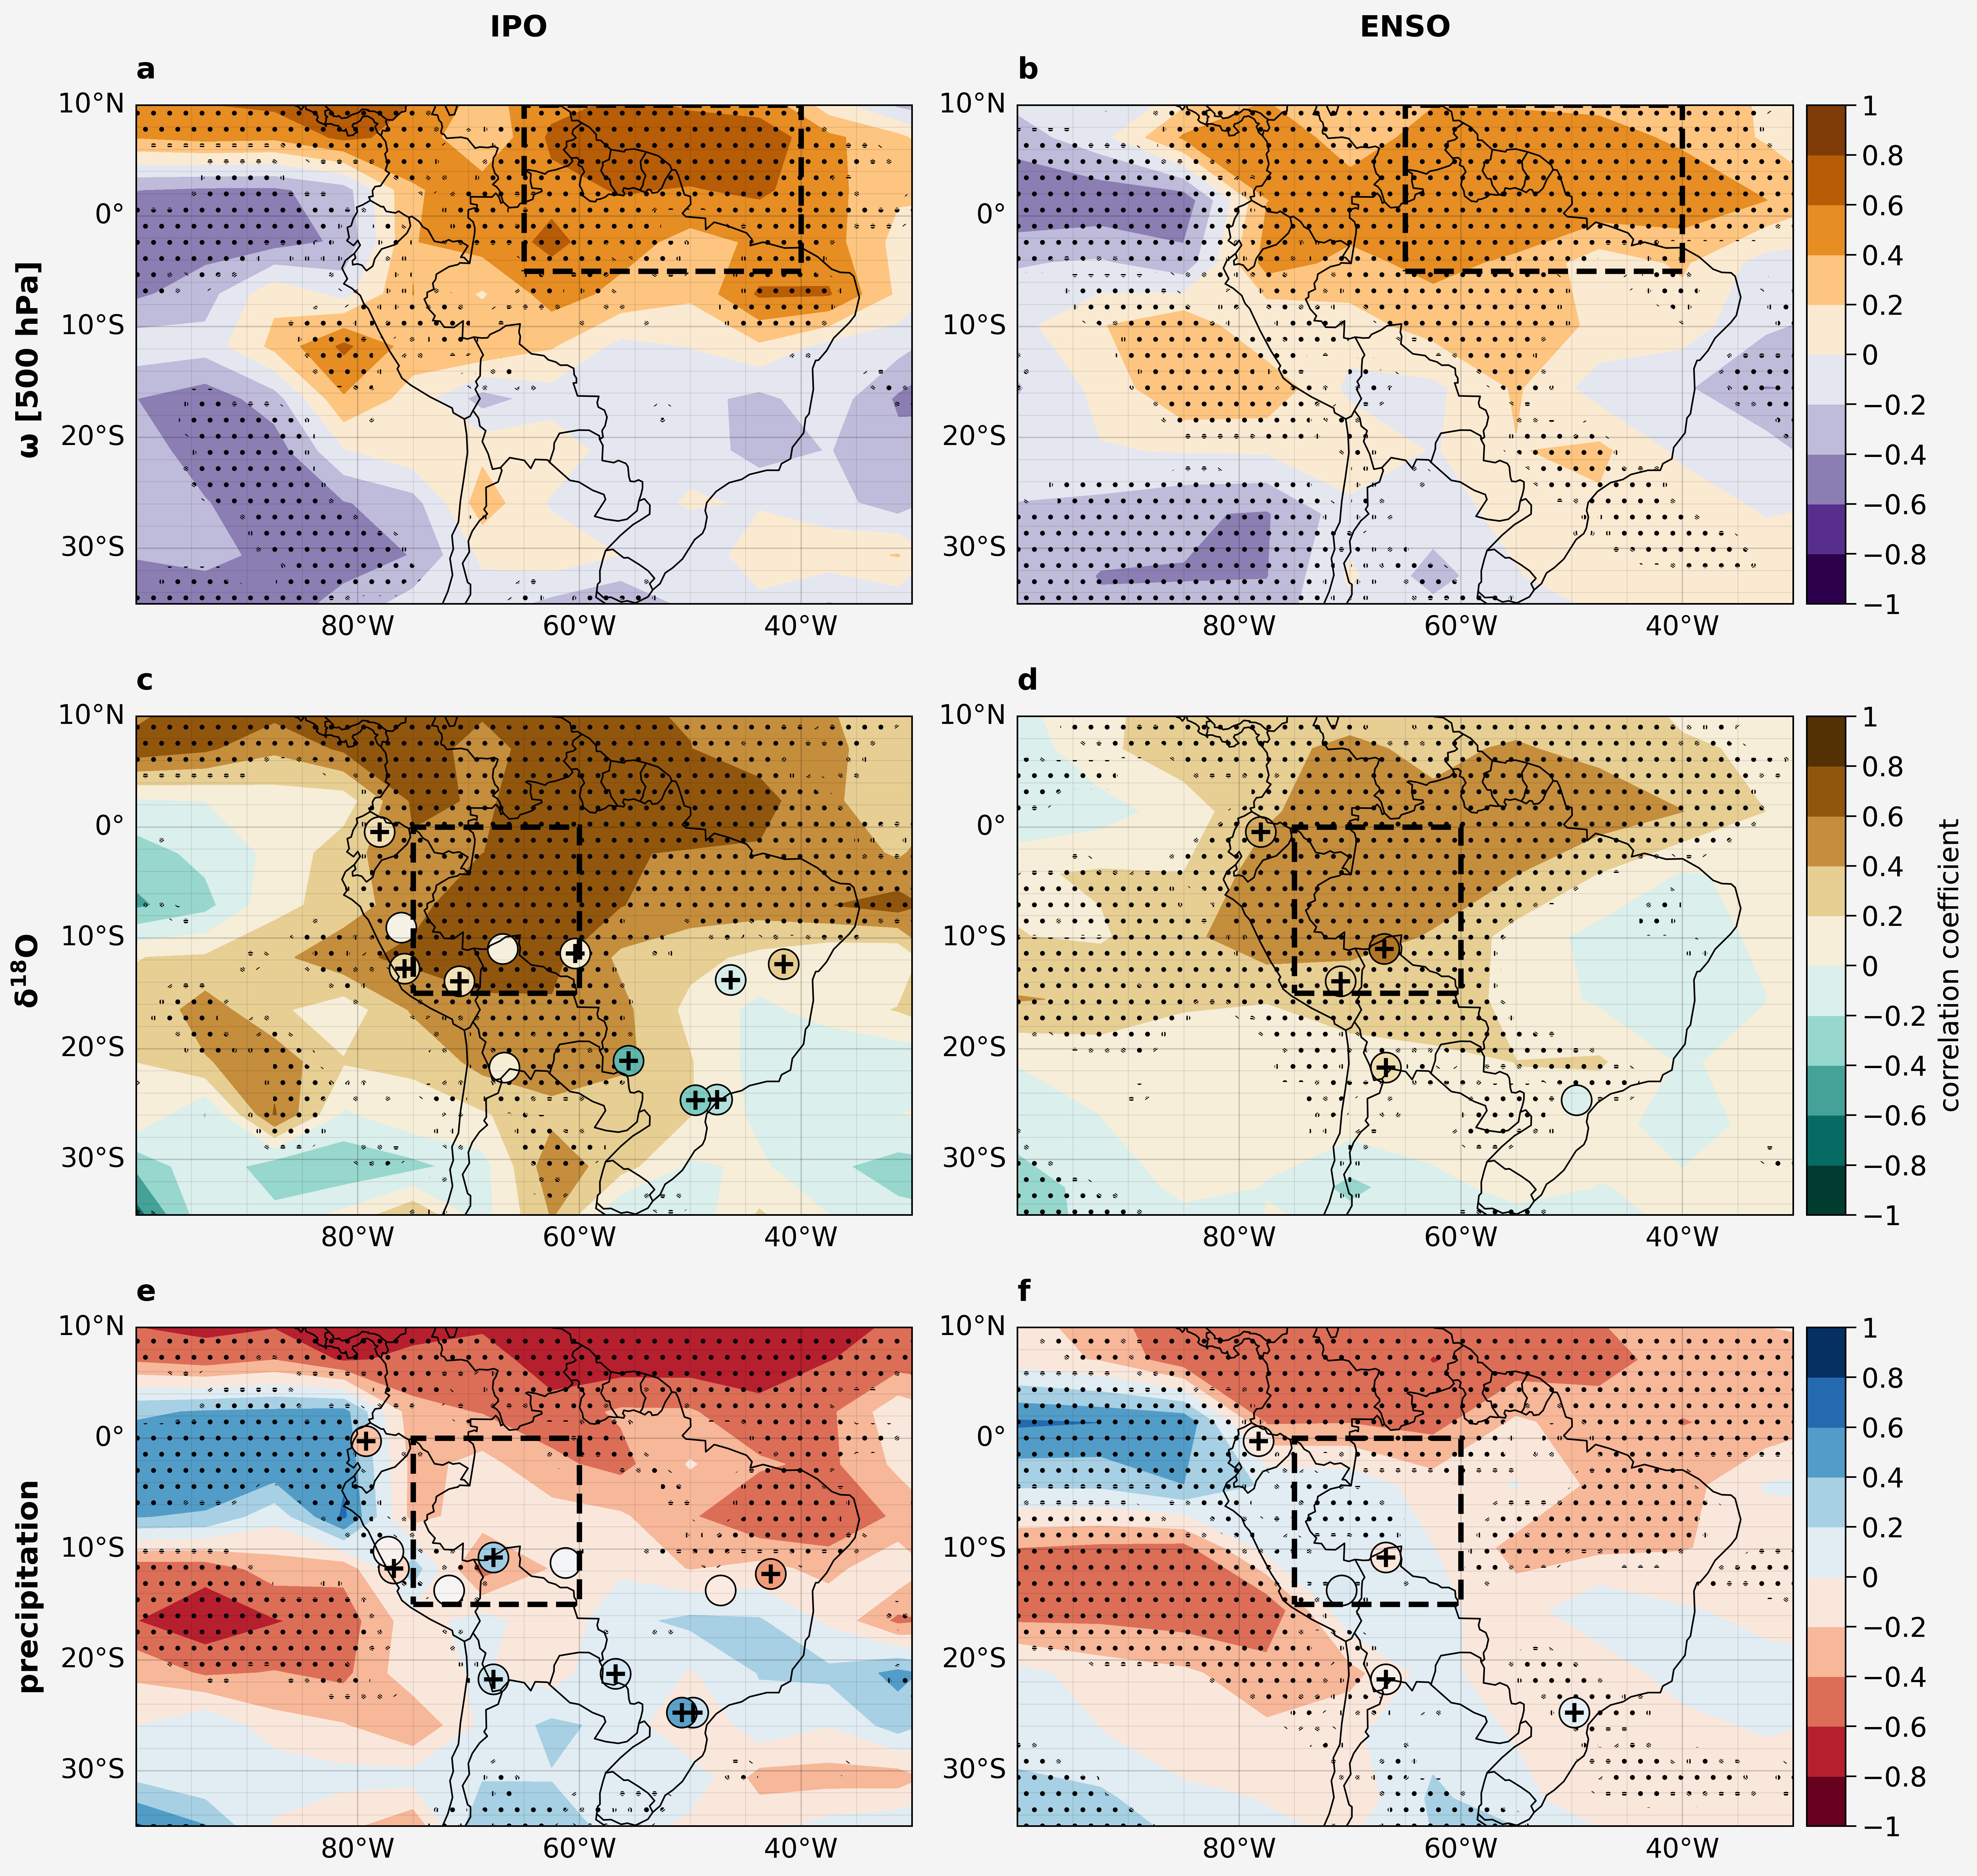

In [12]:
# OFFSET proxy correlations
cmap = ['PuOr_r', 'BrBG_r', 'RdBu']
plt.rc('font', family='sans-serif')
plt.rcParams.update({'font.sans-serif':'Arial'})
plt.rcParams.update({'font.size': 10})

# ------
# Set up plotting framework: 
# ------     
fig, axs = pplt.subplots(ncols=2, nrows=3, axwidth=4, share=3, proj='cyl', dpi=300)
# fig, axs = pplt.subplots(nrows=1, ncols=1, proj=('cyl'),figsize=(8,5), dpi=300)

axs.format(land=False, labels=False, lonlines=20, latlines=10, coast=True, borders = True,
           gridminor=True, abc='a', abcloc='l',
           collabels=['IPO ','ENSO'],
           rowlabels=[r'$\omega$ [500 hPa]  ',r'$\delta^{18}O$  ','precipitation  '],
)
axs.format(lonlim=(260,330), latlim=(-35,10), labels=True)

# -------------------------- PLOTTING -------------------------- 

levs = np.arange(-1.0,1.1,0.2)
skip_i = 5 #IPO: doesn't work: 4
skip_e = 6 #ENSO: doesn't work: 2, 3, 5, 10, 20 #works: 4
# -------------------------- IPO
for n in range(3):
#     axs[n,:].set_title('')
    im = axs[n,0].contourf(lon[::skip_i], lat[::skip_i], cc_ipo[n][::skip_i,::skip_i],levels=levs,cmap=cmap[n])
    hatch = axs[n,0].contourf(lon,lat,hatch_ipo[n], hatches=['', '..'],alpha=0.0)
    if n == 1: # Plotting proxy isotope correlations
        for i,r in enumerate(recs):
            if i == 0: #0'P00H1'
                if prox_p_ipo[r] < 0.05:
                    prox = axs[n,0].scatter(lon_pts[i],lat_pts[i]-1,c=prox_r_ipo[r], s=125,
                                      cmap=cmap[n], vmin=-1.0, vmax=1.0,
                                      edgecolors='black', transform=ccrs.PlateCarree())
                    prox = axs[n,0].scatter(lon_pts[i],lat_pts[i]-1,s=50, marker='+', colors='black', 
                                            zorder=3,transform=ccrs.PlateCarree())
                else:
                    prox = axs[n,0].scatter(lon_pts[i],lat_pts[i]-1,c=prox_r_ipo[r], s=125,
                                      cmap=cmap[n], vmin=-1.0, vmax=1.0,
                                      edgecolors='black', transform=ccrs.PlateCarree())
            elif i == 8: #8'Pumacocha' 
                if prox_p_ipo[r] < 0.05:
                    prox = axs[n,0].scatter(lon_pts[i],lat_pts[i]+1,c=prox_r_ipo[r], s=125,
                                      cmap=cmap[n], vmin=-1.0, vmax=1.0,
                                      edgecolors='black', transform=ccrs.PlateCarree())
                    prox = axs[n,0].scatter(lon_pts[i],lat_pts[i]+1,s=50, marker='+', colors='black', 
                                            zorder=3,transform=ccrs.PlateCarree())
                else:
                    prox = axs[n,0].scatter(lon_pts[i],lat_pts[i]+1,c=prox_r_ipo[r], s=125,
                                      cmap=cmap[n], vmin=-1.0, vmax=1.0,
                                      edgecolors='black', transform=ccrs.PlateCarree())
                
            elif i == 2: # 2'CR1'  
                if prox_p_ipo[r] < 0.05:
                    prox = axs[n,0].scatter(lon_pts[i]+1,lat_pts[i],c=prox_r_ipo[r], s=125,
                                      cmap=cmap[n], vmin=-1.0, vmax=1.0,
                                      edgecolors='black', transform=ccrs.PlateCarree())
                    prox = axs[n,0].scatter(lon_pts[i]+1,lat_pts[i],s=50, marker='+', colors='black', 
                                            zorder=3,transform=ccrs.PlateCarree())
                else:
                    prox = axs[n,0].scatter(lon_pts[i]+1,lat_pts[i],c=prox_r_ipo[r], s=125,
                                      cmap=cmap[n], vmin=-1.0, vmax=1.0,
                                      edgecolors='black', transform=ccrs.PlateCarree())
                
            else: #1'JAR4', 3'SBE3', 4'DV2+TR5+LD12', 5'PIM4', 6'MFZ', 7'Quelccaya', 9'UTU', 10'Cuy', 11'Bol'
                if prox_p_ipo[r] < 0.05:
                    prox = axs[n,0].scatter(lon_pts[i],lat_pts[i],c=prox_r_ipo[r], s=125,
                                      cmap=cmap[n], vmin=-1.0, vmax=1.0,
                                      edgecolors='black', transform=ccrs.PlateCarree())
                    prox = axs[n,0].scatter(lon_pts[i],lat_pts[i],s=50, marker='+', colors='black', 
                                            zorder=3,transform=ccrs.PlateCarree())
                else:
                    prox = axs[n,0].scatter(lon_pts[i],lat_pts[i],c=prox_r_ipo[r], s=125,
                                      cmap=cmap[n], vmin=-1.0, vmax=1.0,
                                      edgecolors='black', transform=ccrs.PlateCarree())
    if n == 2: # Plotting station precipitation correlations
        for i,r in enumerate(recs):
            lati = geo_idx(lat_pts[i],gpcc_lat)
            loni = geo_idx(lon_pts[i],gpcc_lon)
            if gpcc_p_ipo[r] < 0.05:
                pob = axs[n,0].scatter(gpcc_lon[loni]-1,gpcc_lat[lati],c=gpcc_r_ipo[r], s=125,
                                  cmap=cmap[n], vmin=-1.0, vmax=1.0,
                                  edgecolors='black', transform=ccrs.PlateCarree())
                pob = axs[n,0].scatter(gpcc_lon[loni]-1,gpcc_lat[lati],s=50, marker='+', colors='black', 
                                        zorder=3,transform=ccrs.PlateCarree())
            else:
                pob = axs[n,0].scatter(gpcc_lon[loni]-1,gpcc_lat[lati],c=gpcc_r_ipo[r], s=125,
                                  cmap=cmap[n], vmin=-1.0, vmax=1.0,
                                  edgecolors='black', transform=ccrs.PlateCarree())
                
# -------------------------- ENSO
    im = axs[n,1].contourf(lon[::skip_e], lat[::skip_e], cc_enso[n][::skip_e,::skip_e],levels=levs,cmap=cmap[n])
    hatch = axs[n,1].contourf(lon,lat,hatch_enso[n], hatches=['', '..'],alpha=0.0)
    if n == 1: # Plotting isotope correlations
        for i,r in enumerate(recs_enso):
            if r == 'Pumacocha': continue
            else:
                if prox_p_enso[r] < 0.05:
                    prox = axs[n,1].scatter(lon_pts_enso[i],lat_pts_enso[i],c=prox_r_enso[r], s=125,
                                      cmap=cmap[n], vmin=-1.0, vmax=1.0,
                                      edgecolors='black', transform=ccrs.PlateCarree())
                    prox = axs[n,1].scatter(lon_pts_enso[i],lat_pts_enso[i],s=50, marker='+', colors='black', 
                                            zorder=3,transform=ccrs.PlateCarree())
                else:
                    prox = axs[n,1].scatter(lon_pts_enso[i],lat_pts_enso[i],c=prox_r_enso[r], s=125,
                                      cmap=cmap[n], vmin=-1.0, vmax=1.0,
                                      edgecolors='black', transform=ccrs.PlateCarree())    
    if n == 2: # plotting precipitation station correlations
        for i,r in enumerate(recs_enso):
                if r == 'Pumacocha': continue
                else:
                    lati = geo_idx(lat_pts_enso[i],gpcc_lat)
                    loni = geo_idx(lon_pts_enso[i],gpcc_lon)
                    if gpcc_p_ipo[r] < 0.05:
                        pob = axs[n,1].scatter(gpcc_lon[loni],gpcc_lat[lati],c=gpcc_r_enso[r], s=125,
                                          cmap=cmap[n], vmin=-1.0, vmax=1.0,
                                          edgecolors='black', transform=ccrs.PlateCarree())
                        pob = axs[n,1].scatter(gpcc_lon[loni],gpcc_lat[lati],s=50, marker='+', colors='black', 
                                                zorder=3,transform=ccrs.PlateCarree())
                    else:
                        pob = axs[n,1].scatter(gpcc_lon[loni],gpcc_lat[lati],c=gpcc_r_enso[r], s=125,
                                          cmap=cmap[n], vmin=-1.0, vmax=1.0,
                                          edgecolors='black', transform=ccrs.PlateCarree())
# -------------------------- Add colorbar
    if n == 1:
        axs[n,1].colorbar(im, loc='r', label='correlation coefficient', tickloc='right',length=1.0)
    else:
        axs[n,1].colorbar(im, loc='r', label='', tickloc='right',length=1.0)
    
# -------------------------- Add patches for highlighting regions.
    
w500_rec = axs[0,0].add_patch(patches.Rectangle(xy=[295, -5], width=25, height=15,
                            facecolor='none', linestyle = 'dashed', edgecolor='k', lw=2., 
                            transform=ccrs.PlateCarree()))
w500_rec = axs[0,1].add_patch(patches.Rectangle(xy=[295, -5], width=25, height=15,
                            facecolor='none', linestyle = 'dashed', edgecolor='k', lw=2.,
                            transform=ccrs.PlateCarree()))

d18_rec = axs[1,0].add_patch(patches.Rectangle(xy=[285, -15], width=15, height=15,
                                facecolor='none', linestyle = 'dashed', edgecolor='k', lw=2., 
                                transform=ccrs.PlateCarree()))
d18_rec = axs[1,1].add_patch(patches.Rectangle(xy=[285, -15], width=15, height=15,
                                facecolor='none', linestyle = 'dashed', edgecolor='k', lw=2., 
                                transform=ccrs.PlateCarree()))

p_rec = axs[2,0].add_patch(patches.Rectangle(xy=[285, -15], width=15, height=15,
                                facecolor='none', linestyle = 'dashed', edgecolor='k', lw=2., 
                                transform=ccrs.PlateCarree()))
p_rec = axs[2,1].add_patch(patches.Rectangle(xy=[285, -15], width=15, height=15,
                                facecolor='none', linestyle = 'dashed', edgecolor='k', lw=2., 
                                transform=ccrs.PlateCarree()))

# plt.savefig('/network/rit/lab/vuillelab_rit/orrison/Plots/Pac_SAm/ipo_enso_corr/Fig4_IPO_ENSOdt_w_d18opwt_precip_pobs_corr.jpg', format='JPEG',dpi=300)
plt.show()
